In [5]:
import cs_vqe_classes.cs_vqe_circuit as cs_circ
import utils.cs_vqe_tools as cs_tools
import utils.plotting_tools as plot
import utils.circuit_execution_tools as ce
from utils.molecule_tools import get_molecule
from matplotlib import pyplot as plt
import json
from qiskit import IBMQ

with open('data/model_data.json', 'r') as json_file:
    model_data = json.load(json_file)
     
species = list(model_data.keys())
species

['H2_3-21G_SINGLET',
 'H6_STO-3G_SINGLET',
 'H2_6-31G_SINGLET',
 'H2_6-311G_SINGLET',
 'H3+_STO-3G_SINGLET',
 'H3+_3-21G_SINGLET',
 'H3+_STO-3G_SINGLET_alt',
 'HeH+_3-21G_SINGLET',
 'HeH+_3-21G_SINGLET_alt',
 'HeH+_6-311G_SINGLET',
 'H2O_STO-3G_SINGLET',
 'H2O_STO-3G_SINGLET_alt',
 'BeH+_STO-3G_SINGLET',
 'LiH_STO-3G_SINGLET',
 'CH+_STO-3G_SINGLET',
 'HF_STO-3G_SINGLET',
 'B+_STO-3G_SINGLET',
 'N+_STO-3G_SINGLET',
 'OH+_STO-3G_SINGLET',
 'CH2_STO-3G_SINGLET',
 'BeH2_STO-3G_SINGLET',
 'Be_STO-3G_SINGLET',
 'C_STO-3G_SINGLET',
 'NH_STO-3G_SINGLET']

In [6]:
test_data = []
for species in model_data:
    if model_data[species]['num_qubits'] == 5:
        test_data.append(species)
test_data

['H2_3-21G_SINGLET',
 'H2_6-31G_SINGLET',
 'B+_STO-3G_SINGLET',
 'N+_STO-3G_SINGLET',
 'Be_STO-3G_SINGLET',
 'C_STO-3G_SINGLET']

In [7]:
with open('data/token.txt', 'r') as file:
        TOKEN = file.read()
IBMQ.save_account(TOKEN, overwrite=True)
IBMQ.load_account()
try:
    provider = IBMQ.get_provider(hub='ibm-q')
except:
    'Token has probably expired, please regenerate from IBMQ'

/home/ucaptwe/anaconda3/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/ucaptwe/anaconda3/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/ucaptwe/anaconda3/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(
/home/ucaptwe/anaconda3/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(


In [8]:
anz_data = {}
for speciesname in test_data:

    molecule    = model_data[speciesname]
    ham         = molecule['ham']
    uccsd       = molecule['uccsd']
    hf_config   = molecule['hf_config']
    num_qubits  = molecule['num_qubits']
    terms_noncon= molecule['terms_noncon']

    mol_circ = cs_circ.cs_vqe_circuit(hamiltonian =ham,
                                      terms_noncon=terms_noncon,
                                      num_qubits  =num_qubits, 
                                      hf_config   =hf_config)
    
    anz_data[speciesname] = {'num_qubits':num_qubits, 
                             'num_terms':{'full':len(uccsd)},
                             'circdepth':{'full':mol_circ.full_uccsd(uccsd).depth()},
                             'chemaccnum':mol_circ.chem_acc_num_q,
                             'errors':mol_circ.cs_vqe_errors,
                             'csvqedata':{"true_gs":mol_circ.true_gs}}
    
    print(speciesname, mol_circ.chem_acc_num_q, mol_circ.num_qubits)
    
    if mol_circ.chem_acc_num_q != mol_circ.num_qubits and mol_circ.chem_acc_num_q <= 7:
        for num_sim_q in range(1, mol_circ.chem_acc_num_q+1):
            ham_red = mol_circ.ham_reduced[num_sim_q]
            qc = mol_circ.build_circuit(uccsd, num_sim_q)
            cs_vqe_result = ce.remote_VQE(ham_red, qc, mol_circ.init_params)
            #cs_vqe_result = mol_circ.CS_VQE(anz_terms=uccsd, num_sim_q=num_sim_q)
            anz_data[speciesname]['num_terms'][num_sim_q] = len(mol_circ.project_anz_terms_alt(uccsd, num_sim_q))
            anz_data[speciesname]['circdepth'][num_sim_q] = qc.depth()
            #anz_data[speciesname]['csvqedata'][num_sim_q] = cs_vqe_result


H2_3-21G_SINGLET 5 5
H2_6-31G_SINGLET 5 5
B+_STO-3G_SINGLET 3 5


/home/ucaptwe/anaconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/runtime/utils.py:150: UserWarning: Callable <bound method cs_vqe_circuit.init_params of <cs_vqe_classes.cs_vqe_circuit.cs_vqe_circuit object at 0x7f3ec0027d60>> is not JSON serializable and will be set to None.
  warnings.warn(f"Callable {obj} is not JSON serializable and will be set to None.")
/home/ucaptwe/anaconda3/lib/python3.8/site-packages/urllib3/connection.py:379: SystemTimeWarning: System time is way off (before 2020-07-01). This will probably lead to SSL verification errors
  warnings.warn(


N+_STO-3G_SINGLET 0 5
Be_STO-3G_SINGLET 3 5


/home/ucaptwe/anaconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/runtime/utils.py:150: UserWarning: Callable <bound method cs_vqe_circuit.init_params of <cs_vqe_classes.cs_vqe_circuit.cs_vqe_circuit object at 0x7f3ebfcaa7c0>> is not JSON serializable and will be set to None.
  warnings.warn(f"Callable {obj} is not JSON serializable and will be set to None.")


KeyboardInterrupt: 

In [9]:
new_anz_data = {mol:anz_data[mol] for mol in anz_data if (anz_data[mol]['num_qubits']!=anz_data[mol]['chemaccnum'] and not anz_data[mol]['chemaccnum']==0) and anz_data[mol]['chemaccnum']<=7}

In [10]:
[mol for mol in anz_data if mol not in new_anz_data]

['H2_3-21G_SINGLET', 'H2_6-31G_SINGLET', 'N+_STO-3G_SINGLET']

['Be_STO-3G_SINGLET', 'B+_STO-3G_SINGLET']
B+_STO-3G_SINGLET


KeyError: 1

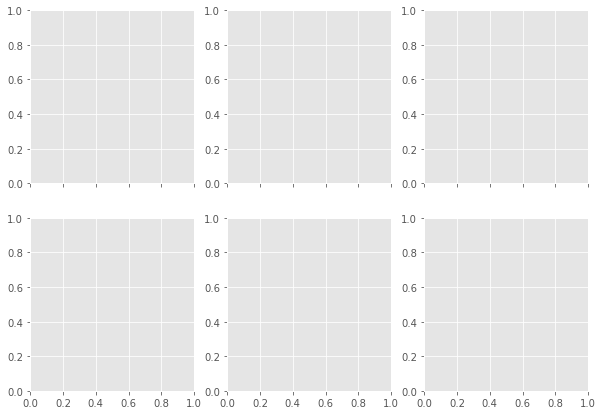

In [12]:
anz_data_sorted = sorted(new_anz_data, key=lambda x:new_anz_data[x]['num_qubits'])
anz_data_sorted.reverse()
print(anz_data_sorted)

fig, axes = plt.subplots(nrows=2, 
                         ncols=3, 
                         figsize = (10, 7), 
                         sharex=True,
                         gridspec_kw={'height_ratios': [1, 1]})
max_qubits = {}

for i, speciesname in enumerate(anz_data_sorted[1:]):
    
    print(speciesname)
    
    c = plt.cm.jet(i/len(new_anz_data))
    if i <=int(len(new_anz_data)/3)-1:
        index = 2
    elif i <=2*int(len(new_anz_data)/3)-1:
        index = 1
    else:
        index = 0
           
    data = new_anz_data[speciesname]
    ca = data['chemaccnum']
    
    if index in max_qubits:
        if max_qubits[index] < data['chemaccnum']:
            max_qubits[index] = data['chemaccnum']
    else:
        max_qubits[index] = data['chemaccnum']
    qubits = list(range(1, ca+1))
    X = [q/data['num_qubits'] for q in qubits]
    Y_depth = [data['circdepth'][i]/data['circdepth']['full'] for i in qubits]
    Y_error = data['errors'][1:ca+1]
    Y_error_sim = []
    for i in range(1, ca+1):
        Y_error_sim.append(data['csvqedata'][i]['result']-data['csvqedata'][i]['true_gs'])
    
    ca_ratio = data['circdepth'][ca]/data['circdepth']['full']
    
    axes[(1, index)].plot(X, Y_depth, color=c, label=speciesname)
    axes[(1, index)].vlines(X[-1], 0, ca_ratio, color=c, ls=':')
    axes[(0, index)].plot(X, Y_error, color=c, ls='--')
    axes[(0, index)].plot(X, Y_error_sim, color=c)
    
    #axes[(0, index)].plot(X_full, Y_anznm_full, color=c, ls='-.')
    #axes[(1, index)].plot(X_full, Y_depth_full, color=c, ls='-.')
    #axes[(0, 1)].set_xticklabels(list(range(1, 14))+['full'])

for i in range(3):
    X = list(range(1,max_qubits[i]+1))
    axes[(0,i)].hlines(0.0016, 0, 1, ls='--', color='black')
    #axes[(0,i)].set_xticks(X)
    #axes[(1,i)].set_xticks(X)
    
axes[(0,1)].hlines(0.0016, 1, 1, label='Chemical accuracy', ls='--', color='black')
axes[(1,0)].set_ylabel('Proportional circuit depth \n(relative to full UCCSD)',fontsize=15)
axes[(0,0)].set_ylabel('Absolute error (Ha)',fontsize=15)
axes[(1,1)].set_xlabel('Proportion of qubits simulated (relative to full system)',fontsize=15)

fig.legend(loc='lower center',bbox_to_anchor=(0.5, -0.13),
          fancybox=True, shadow=True, ncol=4)

In [ ]:
fig.savefig('plots/CS-VQE_paper/reduced_ansatz_depth.png', dpi=300, bbox_inches='tight')

In [6]:
import json 

data={}
for k in anz_data.keys():
    data[str(k)] = anz_data[k]

with open("data/anz_circ_depth.json", "w") as outfile: 
    json.dump(data, outfile)

In [7]:
for mol in anz_data.keys():
    data = anz_data[mol]
    print(mol, data['num_qubits'], data['chemaccnum'])

H2_3-21G_SINGLET 5 5
H6_STO-3G_SINGLET 9 9
H2_6-31G_SINGLET 5 5
H2_6-311G_SINGLET 9 9
H3+_STO-3G_SINGLET 3 3
H3+_3-21G_SINGLET 9 9
HeH+_3-21G_SINGLET 6 6
HeH+_6-311G_SINGLET 10 9
H2O_STO-3G_SINGLET 10 7
BeH+_STO-3G_SINGLET 8 6
LiH_STO-3G_SINGLET 8 4
CH+_STO-3G_SINGLET 8 6
HF_STO-3G_SINGLET 8 4
B+_STO-3G_SINGLET 5 3
N+_STO-3G_SINGLET 5 0
OH+_STO-3G_SINGLET 8 5
CH2_STO-3G_SINGLET 10 8


In [13]:
anz_data

{'H2_3-21G_SINGLET': {'num_qubits': 5,
  'num_terms': {'full': 64},
  'circdepth': {'full': 864},
  'chemaccnum': 5,
  'errors': [0.025078119403551424,
   0.017879349208737905,
   0.013774504595100767,
   0.004963144792198948,
   0.004889531488000198,
   4.218847493575595e-15],
  'csvqedata': {}},
 'H2_6-31G_SINGLET': {'num_qubits': 5,
  'num_terms': {'full': 48},
  'circdepth': {'full': 656},
  'chemaccnum': 5,
  'errors': [0.025138963690992,
   0.01928257099701547,
   0.015048296059208432,
   0.0050807115544004855,
   0.004997600252329981,
   0.0],
  'csvqedata': {}},
 'B+_STO-3G_SINGLET': {'num_qubits': 5,
  'num_terms': {'full': 176, 1: 0, 2: 6, 3: 20},
  'circdepth': {'full': 2331, 1: 2, 2: 62, 3: 271},
  'chemaccnum': 3,
  'errors': [0.04027631825712419,
   0.04027631825712774,
   0.018516820836264714,
   0.00018456213186368586,
   7.824470288397833e-05,
   -1.2079226507921703e-13],
  'csvqedata': {}},
 'N+_STO-3G_SINGLET': {'num_qubits': 5,
  'num_terms': {'full': 112},
  'circd

In [14]:
cs_vqe_result

{'optimizer_evals': None,
 'optimizer_time': 212.40695524215698,
 'optimal_value': -24.144664223066773,
 'optimal_point': array([ 2.09468719, -0.83302445,  0.78413184,  1.81028827,  1.68970605,
         0.97280841,  0.59442693,  0.93610909, -0.46706669,  1.35126694,
        -0.59561748,  1.76810648,  0.79272397,  0.98901102,  2.28125863,
         0.58518713, -0.55927328, -1.31409795,  1.35803865,  0.74441778]),
 'optimal_parameters': None,
 'cost_function_evals': 400,
 'eigenstate': {'000': 0.48814051051092533,
  '001': 0.6643840892441834,
  '010': 0.044197159640830395,
  '011': 0.22316963461281325,
  '100': 0.21650636516167865,
  '101': 0.336572608962006,
  '110': 0.15625025616855895,
  '111': 0.2898004130639273},
 'eigenvalue': (-24.144664223066773+0j),
 'aux_operator_eigenvalues': None,
 'optimizer_history': {'loss': [-22.067961962213666,
   -23.444884008982683,
   -23.794330956347892,
   -23.92119203323461,
   -23.983271098500193,
   -23.994309821325793,
   -24.018134263206314,
   